# Import Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

# Steps

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Camera Calibration

In [2]:
# Create function to return image and object points for an image
def get_cal_points(image,nx,ny):
    
    # Debugplot flag
    debugplot = False
    
    # Initialize image and object points to empty
    objp = []
    imgp = []
    
    # Convert to grayscale
    image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(image_gray, (nx, ny), None)
    
    # If found, update image and object points
    if ret == True:
        objp = np.zeros((nx*ny,3),np.float32)
        objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
        imgp = corners
        
        # Debugplot
        if debugplot:
            plt.figure()
            cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
            plt.imshow(image)
    
    return ret,objp,imgp

# Initialize arrays to store all image and object points
objpoints = []
imgpoints = []

# Go through each file and obtain object and image points
files = os.listdir("camera_cal/")
nx = 9
ny = 6
for file in files:
    image = cv2.imread('camera_cal/' + file)
    ret,objp,imgp = get_cal_points(image,nx,ny)
    if ret:
        objpoints.append(objp)
        imgpoints.append(imgp)

# Obtain camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image.shape[1::-1], None, None)


## Apply distortion correction

Text(0.5, 1.0, 'undistorted')

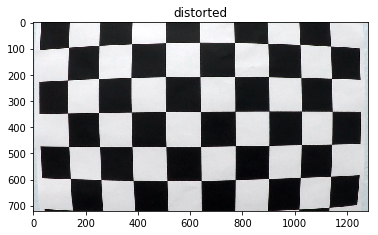

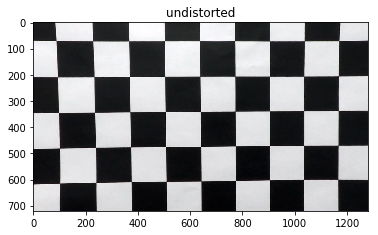

In [3]:
# Undistort an image as an example
image = cv2.imread('camera_cal/calibration1.jpg')
undist = cv2.undistort(image, mtx, dist, None,mtx)
plt.figure()
plt.imshow(image)
plt.title('distorted')
plt.figure()
plt.imshow(undist)
plt.title('undistorted')


## Create thresholded binary image

Text(0.5, 1.0, 'Binary threshold')

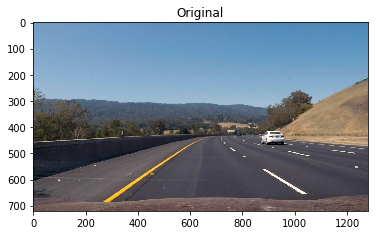

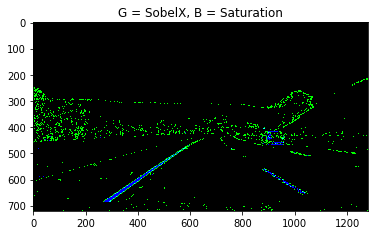

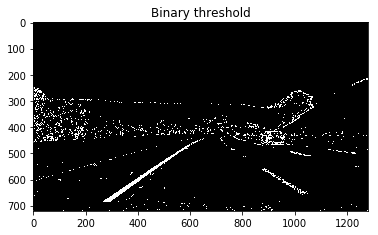

In [4]:
# Function to obtain binary threshold
def get_bin_thresh(image,sx_thresh=(20, 100),sat_thresh=(170, 255)):

    # Grayscale
    image_gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    # Convert to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold sobel x gradient
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold saturation channel
    sat_binary = np.zeros_like(s_channel)
    sat_binary[(s_channel >= sat_thresh[0]) & (s_channel <= sat_thresh[1])] = 1
    
    # Create binary image
    bin_thresh = np.zeros_like(image_gray)
    bin_thresh[(sx_binary > 0) | (sat_binary > 0)]=1
        
    return bin_thresh, sx_binary, sat_binary

# Obtain test image file
image = cv2.imread('test_images/test3.jpg')

# Convert to RGB
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image_org = image # Store for later

# Get binary threshold
bin_thresh, sx_binary, sat_binary = get_bin_thresh(image)

# Get binary threshold image
image_bin_thresh = bin_thresh * 255

plt.figure()
plt.imshow(image)
plt.title('Original')

plt.figure()
color_binary = np.dstack(( np.zeros_like(sx_binary), sx_binary, sat_binary)) * 255
plt.imshow(color_binary)
plt.title('G = SobelX, B = Saturation')

plt.figure()
plt.imshow(image_bin_thresh,cmap = 'gray')
plt.title('Binary threshold')

## Perspective transform

Text(0.5, 1.0, 'Binary warped')

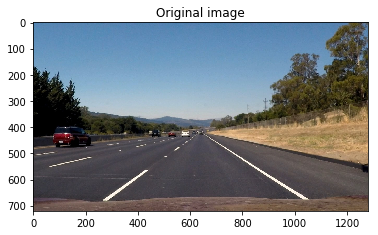

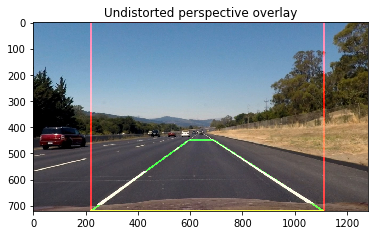

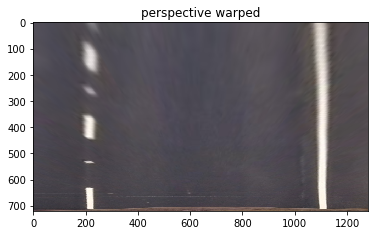

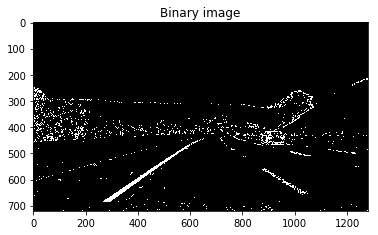

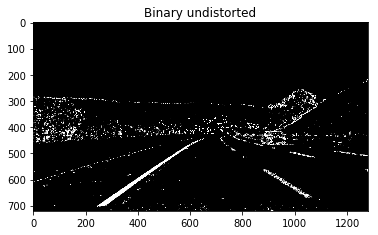

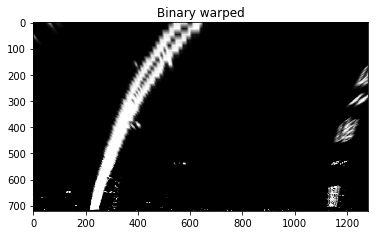

In [5]:
# Obtain test straight image
image = cv2.imread('test_images/straight_lines2.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

height = image.shape[0]
width = image.shape[1]

# Undistort the image
image_undist = cv2.undistort(image, mtx, dist, None,mtx)

# Pick perspective source points
src = np.array([[(220,height),(595,450),(690,450),(1110,height)]],dtype=np.int32)

# Create overalay of source points
overlay_src = np.zeros_like(image_undist)
cv2.polylines(overlay_src,src,True,(0,255,0),5)

# Pick perspective destination points
dst = np.array([[(src[0][0][0],height),(src[0][0][0],0),(src[0][3][0],0),(src[0][3][0],height)]],dtype=np.int32)

# Create overlay of destination points
overlay_dst = np.zeros_like(image_undist)
cv2.polylines(overlay_dst,dst,True,(255,0,0),5)

# Display the source and destination overlays on image
alpha = 0.8
beta = 1
gamma = 0
image_overlayed = cv2.addWeighted(overlay_src,alpha,image_undist,beta,gamma)
image_overlayed = cv2.addWeighted(overlay_dst,alpha,image_overlayed,beta,gamma)

# Get perspective transform
M = cv2.getPerspectiveTransform(np.float32(src),np.float32(dst))
Minv = cv2.getPerspectiveTransform(np.float32(dst),np.float32(src))

# Get warped image
warped = cv2.warpPerspective(image_undist,M,image.shape[1::-1], flags=cv2.INTER_LINEAR)

# Display originial, undistorted and warped images
plt.figure()
plt.imshow(image)
plt.title('Original image')
plt.figure()
plt.imshow(image_overlayed)
plt.title('Undistorted perspective overlay')
plt.figure()
plt.imshow(warped)
plt.title('perspective warped')

# Perform correction for binary image

# Undistort the image
image = image_bin_thresh
image_undist = cv2.undistort(image, mtx, dist, None,mtx)
image_bin_warped = cv2.warpPerspective(image_undist,M,image.shape[1::-1], flags=cv2.INTER_LINEAR)
plt.figure()
plt.imshow(image,cmap = 'gray')
plt.title('Binary image')
plt.figure()
plt.imshow(image_undist,cmap = 'gray')
plt.title('Binary undistorted')
plt.figure()
plt.imshow(image_bin_warped, cmap = 'gray')
plt.title('Binary warped')
 


## Lane detection

Text(0.5, 1.0, 'Search around fit')

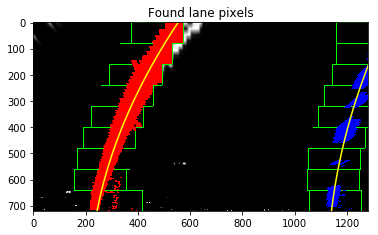

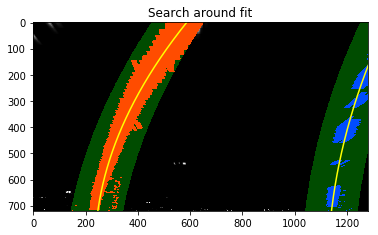

In [6]:
# Function to find lane pixels from binary warped image
def find_lane_pixels(image):
    
    height = image.shape[0]
    width = image.shape[1]
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(image[height//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    image_out = np.dstack((image,image,image))
    
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # number of sliding windows
    nwindows = 9
    # width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(height/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = height - (window+1)*window_height
        win_y_high = height - window*window_height
    
        #Find the four below boundaries of the window
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(image_out,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(image_out,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### Identify the nonzero pixels in x and y within the window
        good_left_inds = np.where((nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high) & (nonzeroy >= win_y_low) & (nonzeroy < win_y_high))[0] 
        good_right_inds = np.where((nonzerox >= win_xright_low) & (nonzerox < win_xright_high) & (nonzeroy >= win_y_low) & (nonzeroy < win_y_high))[0] 
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.average(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.average(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Colors in the left and right lane regions
    image_out[lefty, leftx] = [255, 0, 0]
    image_out[righty, rightx] = [0, 0, 255]

    return leftx, lefty, rightx, righty, image_out

# Function to search around polynomial
def search_around_poly(binary_warped, left_fit,right_fit):
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values
    win_left_mid = left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2]
    win_left_low = win_left_mid-margin
    win_left_high = win_left_mid + margin
    left_lane_inds = np.where((nonzerox > win_left_low) & (nonzerox < win_left_high))[0]
    win_right_mid = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2]
    win_right_low = win_right_mid-margin
    win_right_high = win_right_mid + margin
    right_lane_inds = np.where((nonzerox > win_right_low) & (nonzerox < win_right_high))[0]
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    ploty = np.linspace(0,binary_warped.shape[0]-1,binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return leftx, lefty, rightx, righty, result

# Function to fit polynomial to binary warped image
def fit_polynomial(image_shape,leftx,lefty,rightx,righty,xm_per_pix = 30/720,ym_per_pix = 3.7/700):
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)

    # Generate x and y values for plotting
    ploty = np.linspace(0,image_shape[0]-1,image_shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Fit a second order polynomial to each
    left_fit_cr = np.polyfit(lefty * ym_per_pix,leftx * xm_per_pix,2)
    right_fit_cr = np.polyfit(righty* ym_per_pix,rightx * xm_per_pix,2)

    return left_fit, right_fit, left_fit_cr, right_fit_cr, left_fitx, right_fitx, ploty

leftx, lefty, rightx, righty, image_out = find_lane_pixels(image_bin_warped)
left_fit, right_fit, left_fit_cr, right_fit_cr, left_fitx, right_fitx, ploty = fit_polynomial(image_bin_warped.shape,leftx,lefty,rightx,righty)

plt.figure()
plt.plot(left_fitx,ploty,color = 'yellow')
plt.plot(right_fitx,ploty,color = 'yellow')
plt.imshow(image_out)
plt.title('Found lane pixels')

leftx, lefty, rightx, righty, image_out = search_around_poly(image_bin_warped,left_fit,right_fit)
left_fit, right_fit, left_fit_cr, right_fit_cr, left_fitx, right_fitx, ploty = fit_polynomial(image_bin_warped.shape,leftx,lefty,rightx,righty)

plt.figure()
plt.plot(left_fitx,ploty,color = 'yellow')
plt.plot(right_fitx,ploty,color = 'yellow')
plt.imshow(image_out)
plt.title('Search around fit')

    

## Determine curvature

In [7]:
def get_curvature(left_fit_cr,right_fit_cr, y_eval):
    
    left_curverad = ((1+(2*left_fit[0]*y_eval + left_fit[1])**2)**(3/2))/(2*left_fit[0]) 
    right_curverad = ((1+(2*right_fit[0]*y_eval + right_fit[1])**2)**(3/2))/(2*right_fit[0])
    
    return left_curverad, right_curverad

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

y_eval = np.max(ploty*ym_per_pix)
left_curverad, right_curverad = get_curvature(left_fit_cr,right_fit_cr,y_eval)

print(left_curverad,right_curverad)

2200.096166196179 2734.9815984698103


## Warp back to image

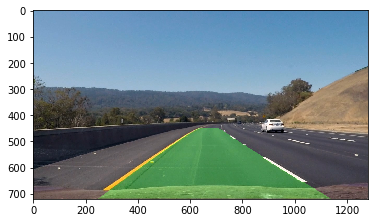

In [8]:

def get_lane_unwarped(image_bin_warped,left_fitx,right_fitx,ploty,Minv):
    
    # Create an image to draw the lines on
    image_lane_warped = np.zeros_like(image_bin_warped)
    image_lane_warped = np.dstack((image_lane_warped,image_lane_warped,image_lane_warped))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(image_lane_warped, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    image_lane_unwarped = cv2.warpPerspective(image_lane_warped, Minv,image_bin_warped.shape[1::-1],) 
    
    return image_lane_unwarped

image_lane_unwarped = get_lane_unwarped(image_bin_warped,left_fitx,right_fitx,ploty,Minv)

# Combine the result with the original image
image_lane_filled = cv2.addWeighted(image_org,1,image_lane_unwarped, 0.3, 0)

plt.imshow(image_lane_filled)

## Output display

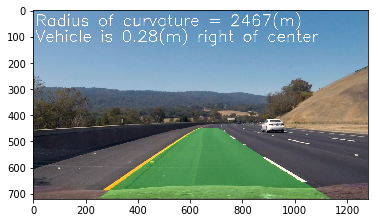

In [16]:
image_final = np.copy(image_lane_filled)

# Get radius of curvature
curve_rad = np.int((left_curverad + right_curverad)/2)

# Get offset
offset = np.int(((left_fitx[-1] + right_fitx[-1])/2 - image_final.shape[1]/2)*xm_per_pix * 100)/100

# Display radius of curvature
cv2.putText(image_final,'Radius of curvature = '+ str(curve_rad) + '(m)',(10,60),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),2,cv2.LINE_AA)

# Display offset
if offset > 0:
    cv2.putText(image_final,'Vehicle is '+ str(offset) + '(m) right of center',(10,120),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),2,cv2.LINE_AA)
else:
    cv2.putText(image_final,'Vehicle is '+ str(-offset) + '(m) left of center',(10,120),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),2,cv2.LINE_AA)
plt.imshow(image_final)

## Create the pipeline

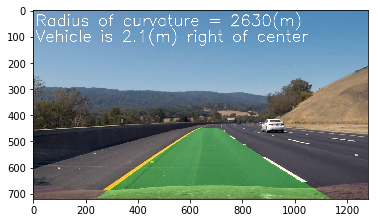

In [21]:
def pipeline(image):

    sx_thresh=(20, 100)
    sat_thresh=(170, 255)
    xm_per_pix = 30/720
    ym_per_pix = 3.7/700

    # Undistort the image
    image_undist = cv2.undistort(image, mtx, dist, None,mtx)

    # Get binary threshold
    bin_thresh, sx_binary, sat_binary = get_bin_thresh(image_undist,sx_thresh,sat_thresh)

    # Get binary threshold image
    image_bin_thresh = bin_thresh * 255

    # Get perspective warped binary threshold image
    image_bin_warped = cv2.warpPerspective(image_bin_thresh,M,image_bin_thresh.shape[::-1], flags=cv2.INTER_LINEAR)

    # Find lane pixels from scratch
    leftx, lefty, rightx, righty, image_out = find_lane_pixels(image_bin_warped)

    # Fit polynomial to found lane pixels
    left_fit, right_fit, left_fit_cr, right_fit_cr, left_fitx, right_fitx, ploty = fit_polynomial(image_bin_warped.shape,leftx,lefty,rightx,righty,xm_per_pix,ym_per_pix)

    # Determine curvature
    y_eval = np.max(ploty*ym_per_pix)
    left_curverad, right_curverad = get_curvature(left_fit_cr,right_fit_cr,y_eval)

    # Warp back to image
    image_lane_unwarped = get_lane_unwarped(image_bin_warped,left_fitx,right_fitx,ploty,Minv)

    # Combine the result with the original image
    image_final = cv2.addWeighted(image,1,image_lane_unwarped, 0.3, 0)

    # Get radius of curvature
    curve_rad = np.int((left_curverad + right_curverad)/2)

    # Get offset
    offset = np.int(((left_fitx[-1] + right_fitx[-1])/2 - image_final.shape[1]/2)*xm_per_pix * 100)/100

    # Display radius of curvature
    cv2.putText(image_final,'Radius of curvature = '+ str(curve_rad) + '(m)',(10,60),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),2,cv2.LINE_AA)

    # Display offset
    if offset > 0:
        cv2.putText(image_final,'Vehicle is '+ str(offset) + '(m) right of center',(10,120),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),2,cv2.LINE_AA)
    else:
        cv2.putText(image_final,'Vehicle is '+ str(-offset) + '(m) left of center',(10,120),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),2,cv2.LINE_AA)
        
    return image_final

# Obtain test image file
image = cv2.imread('test_images/test3.jpg')

# Convert to RGB
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

# Run pipeline
plt.imshow(pipeline(image))


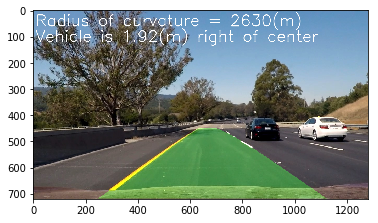

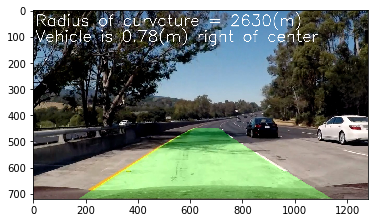

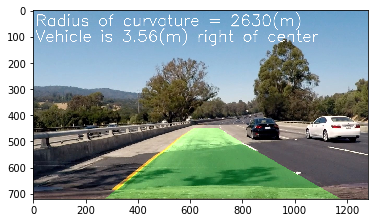

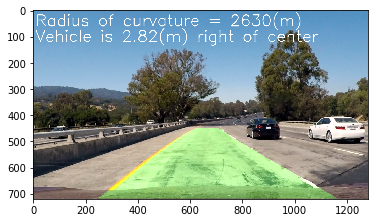

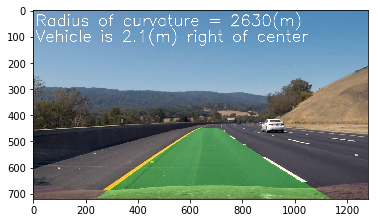

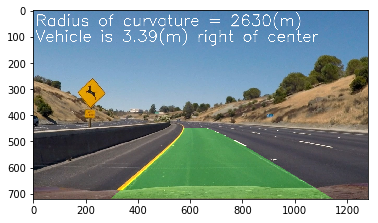

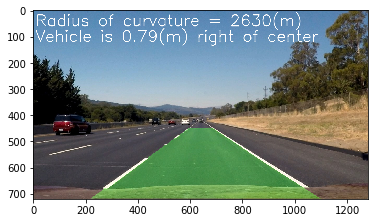

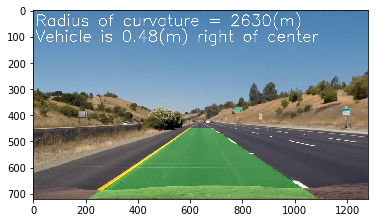

In [25]:
# Run pipeline on each image in test image directory and save
files = os.listdir("test_images/")
for file in files:
    image = cv2.imread('test_images/' + file)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    result = pipeline(image)
    plt.figure()
    plt.imshow(result)
    #plt.imsave('test_images_output/'+file,lines_image)